# Import Street Network using OSMNX

In [22]:
import sys
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
sys.path.insert(0, r'../../../quetzal')

import geopandas as gpd
from shapely import geometry
import osmnx as ox
import geopandas as gpd

from quetzal.model.stepmodel import StepModel
from syspy.spatial.graph.graphbuilder import OsmnxCleaner

if manual:
    %matplotlib inline
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

In [23]:
training_folder = '../../'
input_folder = training_folder + 'inputs/'

# OSMNX API

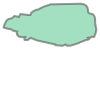

In [24]:
# Import polygon (hull) is based on model zones
zones = gpd.read_file(input_folder + 'zones/zones.geojson')
hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)
hull

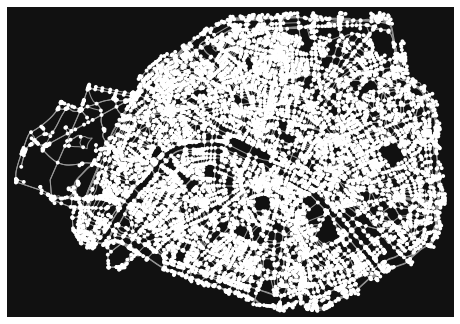

In [25]:
# OSMNX Call
drive = ox.graph_from_polygon(hull, network_type='drive')
drive = ox.speed.add_edge_speeds(drive)
plot = ox.plot_graph(drive)

# Convert OSMNX Graph to links and nodes

In [26]:
road_nodes, road_links = ox.graph_to_gdfs(drive)
road_links = road_links.reset_index()
road_nodes = road_nodes.reset_index()

road_links.rename(columns={'u': 'a', 'v': 'b', 'speed_kph': 'speed'}, inplace=True)
road_links['time'] = road_links['length']/(road_links['speed']*1000/3600)
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]
road_links[['a', 'b']] = road_links[['a', 'b']].astype(str)

# Cleaning

In [27]:
# Simplify geometry
from shapely import geometry
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])

road_links['geometry'] = road_links['geometry'].apply(simplify_link)

In [28]:
# Add reversed geometry 
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='a', 
    b='b'
)

oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
oc.clean_geometries()
oc.fix_nodeset_consistency()

In [29]:
# Remove ireelevant route types
sm = StepModel(epsg=4326, coordinates_unit='degree')
sm.road_links = oc.links[['a', 'b', 'speed', 'time', 'length', 'geometry', 'highway']].copy()
sm.road_nodes = oc.nodes[['geometry']].copy()

sm.road_links['highway'] = sm.road_links['highway'].astype(str)
irrelevant = ['pedestrian', 'footway', 'service', 'cycleway', 'residential']
sm.road_links = sm.road_links.loc[~sm.road_links['highway'].isin(irrelevant)]

sm.integrity_fix_road_network(cutoff=10, recursive_depth=10)

direct: 6059it [00:00, 18831.03it/s]
reversed: 6059it [00:00, 18205.01it/s]
5698it [00:00, 14283.97it/s]


# Export 

In [30]:
sm.road_links = sm.road_links.drop_duplicates('geometry')
sm.to_json(input_folder + 'road', only_attributes=['road_links', 'road_nodes'])

to_hdf(overwriting): 100%|██████████| 10/10 [00:01<00:00,  7.89it/s]


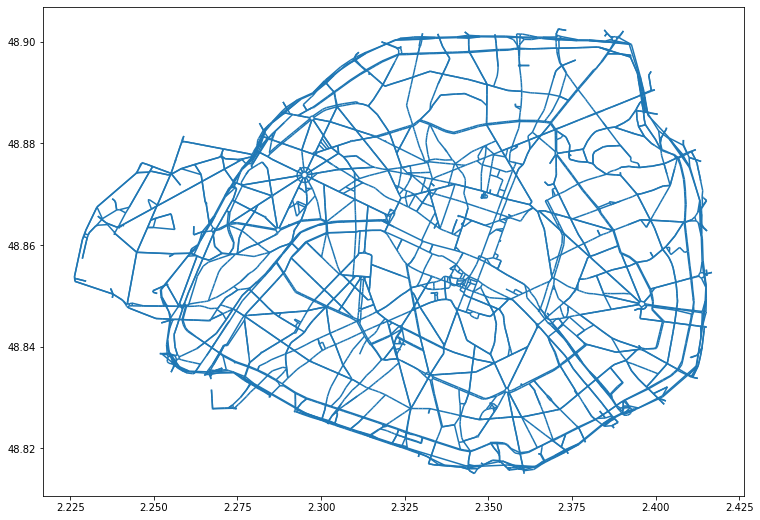

In [31]:
if manual:
    sm.road_links.plot()